In [39]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import sys  
sys.path.insert(0, '../')

from test_library     import  plot_confusion_matrix, plot_Feature_Importance_withSTD, class_train_model_and_classify
from muwclass_library import class_prepare, class_train_and_classify, class_save_res, col_rename, confident_flag, confident_sigma, find_confident, plot_classifier_matrix_withSTD, prepare_cols
from other_libaray import prepare_field, dict_update, combine_class_result, plot_bbsed, plot_class_matrix, prepare_evts_plot_xray_class, interactive_Ximg_class, CMweight_probability

import time
from pathlib import Path
import multiprocessing as mp

In [13]:
field_name  = 'NGC3532_02182022'

RA = 166.28875

DEC = -58.85

data_dir = f'./data/{field_name}' # data directory to save the file

dir_out = f'./{field_name}_results' # classification results directory
dir_plot = dir_out+'/plot' # plots directory
Path(dir_out).mkdir(parents=True, exist_ok=True)
Path(dir_plot).mkdir(parents=True, exist_ok=True)

In [14]:
TD = pd.read_csv('../../files/CSC_TD_MW_remove.csv')
TD['Class'] = TD['Class'].replace({'NS_BIN':'LMXB'})
TD = prepare_cols(TD, cp_thres=0, TD=True, NS_MWdrop=False, STAR_classremove=['HM-STAR','LM-STAR','YSO']) # some filtering 

field = pd.read_csv(f'{data_dir}/{field_name}_MW_clean_update.csv')

print(len(field[field.name.isin(TD.name)]), 'field sources are in the TD:')
print(TD.loc[TD.name.isin(field.name), ['name','Class']])
#TD.loc[TD.name.isin(field.name), :].to_csv(f'{data_dir}/TD_{field_name}_MW_remove.csv',index=False)
field = field[~field.name.isin(TD.name)].reset_index(drop=True)
field.to_csv(f'{data_dir}/{field_name}_MW_remove.csv',index=False)


field = prepare_cols(field, cp_thres=-4, vphas=True,gaiadata=True)


# tbabs from xpsec Wilms, Allen & McCray (2000)
tbabs_ene, tbabs_cross = np.loadtxt('../../files/tbabs.data', skiprows=0)
tbabs_cross *= 100

Remove 21 [('LM-STAR', 1), ('YSO', 20)]
Final breakdown 2941 [('AGN', 1390), ('CV', 44), ('HM-STAR', 118), ('HMXB', 26), ('LM-STAR', 207), ('LMXB', 65), ('NS', 87), ('YSO', 1004)]
0 field sources are in the TD:
Empty DataFrame
Columns: [name, Class]
Index: []


/tmp/ipykernel_3752/2329370765.py:1: DtypeWarning: Columns (314,315,316,317) have mixed types. Specify dtype option on import or set low_memory=False.
  TD = pd.read_csv('../../files/CSC_TD_MW_remove.csv')


In [15]:
Xcat = 'CSC' # CSCv2 catalog is used 
Uncer_flag = True # applying Monte-Carlo samplings to account the measurement uncertainties 
num_sample = 1000 # number of MC samplings, we use 1000 for our classification results in https://arxiv.org/abs/2206.13656, 100 is runnable with a few minutes on a laptop
class_labels = ['AGN','CV','HM-STAR','LM-STAR','HMXB','LMXB','NS','YSO'] # there are 8 classes of X-ray sources in our current pipeline 


In [16]:
# this step takes a few minutes, and it increases linearly as you increase the num_sample (number of MC samplings)

num_cores = mp.cpu_count()
pool = mp.Pool(int(num_cores))

%time arr = [pool.apply(class_prepare, args=(TD, field, True, RA, DEC, Xcat, 'nodist', Uncer_flag, i, i, tbabs_ene, tbabs_cross)) for i in range(num_sample)]


CPU times: user 10.8 s, sys: 3.93 s, total: 14.7 s
Wall time: 4min 50s


In [20]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier

model_dict = {
    'RF': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
    'SVC':SVC(gamma='auto',probability=True), 
    'KNeighbor': KNeighborsClassifier(n_neighbors=10),
    'bagging': BaggingClassifier(), 
    'extratrees': ExtraTreesClassifier(n_estimators=300), 
    'GB': GradientBoostingClassifier()
}

model = 'RF' # you can add models into the model list above and change the model that you want to use here

In [21]:
%%time
# this step takes a few minutes

arr2 = list(zip(arr, [model_dict[model]]*len(arr)))

if __name__ == '__main__':
    
    with mp.Pool() as pool:
        res = pool.map(class_train_model_and_classify, arr2) 
#print(res)
class_save_res(res, dir_out)

CPU times: user 4.25 s, sys: 2.02 s, total: 6.27 s
Wall time: 3min 32s


In [45]:
df_all = pd.read_csv(f'{dir_out}/classes.csv')
df_mean = df_all.groupby('name').mean().iloc[:,:len(class_labels)]

df_std = df_all.groupby('name').std().iloc[:,:len(class_labels)]

df_class = df_mean.idxmax(axis=1)
df_prob = df_mean.max(axis=1)
df_prob_e = pd.DataFrame(data=[df_std.values[i][np.argmax(np.array(df_mean), axis=1)[i]]  for i in range(len(df_std))], columns=['Class_prob_e'])
df_mean = df_mean.add_prefix('P_')
df_std  = df_std.add_prefix('e_P_')

df = pd.concat([pd.concat([df_mean, df_std, df_class, df_prob], axis=1).rename(columns={0:'Class',1:'Class_prob'}).rename_axis('name').reset_index(), df_prob_e], axis=1)

df = confident_flag(df, class_cols=class_labels)
df = confident_sigma(df, class_cols=class_labels)

df_MW = pd.read_csv(f'{data_dir}/{field_name}_MW_remove.csv')
df_MW = prepare_cols(df_MW, cp_thres=-4, vphas=True,gaiadata=True)
df_MW.to_csv('test.csv',index=False)
df_comb = pd.merge(df, df_MW, on="name")

df_save = df_comb.rename(columns={'PU':'PU_X','Fcsc_s':'F_s','Fcsc_m':'F_m','Fcsc_h':'F_h','flux_aper90_ave_b':'F_b',\
                        'Gmag':'G','BPmag':'BP','RPmag':'RP','Jmag':'J','Hmag':'H','Kmag':'K','W1mag':'W1','W2mag':'W2','W3mag':'W3',\
                        'var_intra_prob':'P_intra', 'var_inter_prob':'P_inter'})

mwbands = ['G','BP', 'RP', 'J','H', 'K', 'W1', 'W2', 'W3']
df_save['cp_flag'] = 1
df_save.loc[df_save[mwbands].isna().all(axis=1), 'cp_flag']=0
df_save['cp_counts'] = 0

for band in mwbands:
    df_save.loc[~df_save[band].isna(), 'cp_counts']=df_save.loc[~df_save[band].isna(), 'cp_counts']+1
df_save['HR_hms'] = (df_save['F_h']-df_save['F_m']-df_save['F_s'])/(df_save['F_h']+df_save['F_m']+df_save['F_s'])

class_prob_columns = [ 'P_'+c for c in class_labels]+[  'e_P_'+c for c in class_labels]
df_save[['name','ra','dec','PU_X','significance','F_b','HR_hms','P_inter','P_intra','G','J','W1','cp_counts','CSC_flags','Class','Class_prob','Class_prob_e','conf_flag','CT']+\
    class_prob_columns].to_csv(f'{dir_out}/{field_name}_class.csv',index=False)

field_mw_class = df_save

In [41]:
field_XCLASS = df_save.rename(columns={'significance':'Signif.'})


TD_evaluation = pd.read_csv('./data/LOO_classes.csv')
field_mw_class = combine_class_result(field_name, data_dir, dir_out, class_labels, TD_evaluation,radius)#,weight_CM=True)

field_XCLASS = field_mw_class.rename(columns={'significance':'Signif.'})



In [42]:
CT_cut = 2 # which can be changed

field_XCLASS.loc[field_XCLASS.CT>=CT_cut,['name','ra','dec','Class','F_b','F_h','F_m','F_s','P_inter','P_intra','Signif.','G','BP','RP','J','H','K','W1','W2','W3']].to_csv(f'{dir_out}/{field_name}_XCLASS.csv')


<AxesSubplot:title={'center':'Confident Classification'}>

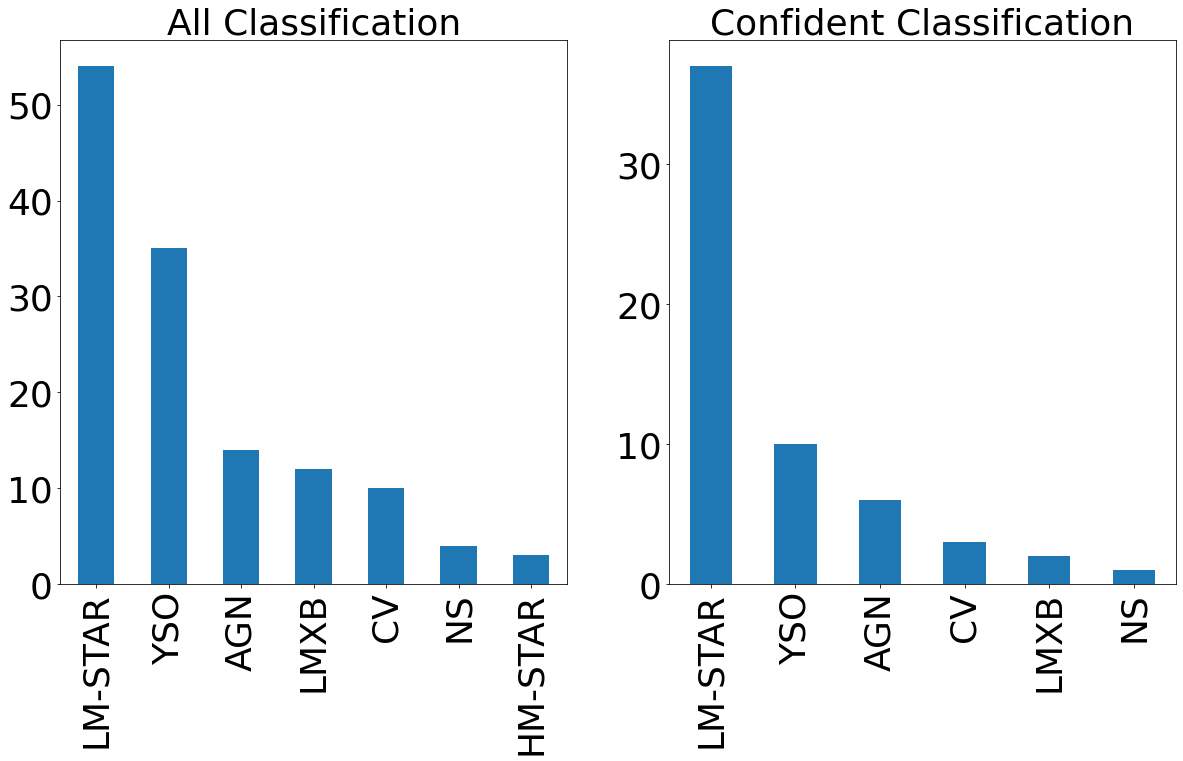

In [44]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
field_mw_class['Class'].value_counts().plot(kind='bar', ax=ax1, title='All Classification')
field_mw_class[field_mw_class.CT>=CT_cut]['Class'].value_counts().plot(kind='bar', ax=ax2,title='Confident Classification')


In [62]:

class_pre = pd.read_csv('./data/NGC3532_class_previous.csv')

print(len(field_mw_class), len(class_pre))

print(field_mw_class.columns)
print(class_pre.columns)

field_mw_class['name']  = field_mw_class['name'].str.strip()
class_pre['name'] = class_pre['name'].str.strip()

#print(field_mw_class['name'], class_pre['name'])


132 132
Index(['name', 'P_AGN', 'P_CV', 'P_HM-STAR', 'P_HMXB', 'P_LM-STAR', 'P_LMXB',
       'P_NS', 'P_YSO', 'e_P_AGN',
       ...
       'cp_flag_comb', 'G', 'e_Gmag', 'BP', 'e_BPmag', 'RP', 'e_RPmag',
       'cp_flag', 'cp_counts', 'HR_hms'],
      dtype='object', length=129)
Index(['Unnamed: 0', 'name', 'Class', 'Class_prob', 'Class_prob_e', 'P_AGN',
       'e_P_AGN', 'P_CV', 'e_P_CV', 'P_HM-STAR',
       ...
       'BP-RP', 'Jmag-Hmag', 'W1mag-W2mag', 'Jmag-W2mag', 'HRMS', 'HRHM',
       'Class_2', 'Class_prob_2', 'Class_prob_e_2', 'CT8'],
      dtype='object', length=141)


In [63]:
class_compare = pd.merge(field_mw_class, class_pre[['name','Class_2','CT8']], on='name',how='inner')

In [64]:
class_compare

,name,P_AGN,P_CV,P_HM-STAR,P_HMXB,P_LM-STAR,P_LMXB,P_NS,P_YSO,e_P_AGN,e_P_CV,e_P_HM-STAR,e_P_HMXB,e_P_LM-STAR,e_P_LMXB,e_P_NS,e_P_YSO,Class,Class_prob,Class_prob_e,conf_flag,CT,ra,dec,PU_X,significance,F_s,e_Fcsc_s,F_m,e_Fcsc_m,F_h,e_Fcsc_h,F_b,e_flux_aper90_ave_b,P_intra,P_inter,CSC_flags,EDR3Name_gaia,RA_pmcor_gaia,DEC_pmcor_gaia,Gmag_gaia,e_Gmag_gaia,BPmag_gaia,e_BPmag_gaia,RPmag_gaia,e_RPmag_gaia,Plx,e_Plx,PM,rgeo,b_rgeo,B_rgeo,rpgeo,b_rpgeo,B_rpgeo,cp_flag_gaia,_2MASS_2mass,J,e_Jmag,H,e_Hmag,K,e_Kmag,cp_flag_2mass,Name_catwise,W1mag_catwise,e_W1mag_catwise,W2mag_catwise,e_W2mag_catwise,cp_flag_catwise,objID_unwise,W1mag_unwise,e_W1mag_unwise,W2mag_unwise,e_W2mag_unwise,cp_flag_unwise,AllWISE_allwise,W1mag_allwise,e_W1mag_allwise,W2mag_allwise,e_W2mag_allwise,W3,e_W3mag,W4mag,e_W4mag,cp_flag_allwise,VPHASDR2_vphas,Gmag_vphas,RPmag_vphas,BPmag_vphas,e_Gmag_vphas,e_RPmag_vphas,e_BPmag_vphas,cp_flag_vphas,_2MASS_2mass_gaia,Jmag_2mass_gaia,e_Jmag_2mass_gaia,Hmag_2mass_gaia,e_Hmag_2mass_gaia,Kmag_2mass_gaia,e_Kmag_2mass_gaia,cp_flag_2mass_gaia,AllWISE_allwise_gaia,W1mag_allwise_gaia,e_W1mag_allwise_gaia,W2mag_allwise_gaia,e_W2mag_allwise_gaia,W3mag_allwise_gaia,e_W3mag_allwise_gaia,W4mag_allwise_gaia,e_W4mag_allwise_gaia,cp_flag_allwise_gaia,cp_flag_wise12,which_wise12,W1,e_W1mag,W2,e_W2mag,which_gaia,cp_flag_comb,G,e_Gmag,BP,e_BPmag,RP,e_RPmag,cp_flag,cp_counts,HR_hms,Class_2,CT8
0,2CXO J110355.5-584754,0.000050,0.001510,0.105985,0.000160,0.884050,0.000590,0.000010,0.007645,0.000706,0.004674,0.081376,0.001406,0.087118,0.003401,0.000316,0.011163,LM-STAR,0.884050,0.087118,1,4.617775,165.981625,-58.798367,2.339643,6.05,5.572798e-15,9.685001e-16,5.661073e-16,2.369898e-16,2.660319e-15,1.973800e-15,8.799224e-15,2.211344e-15,0.473,NaN,NaN,Gaia EDR3 5338702386868676736,165.981718,-58.798269,10.676302,0.002760,10.861904,0.002817,10.353867,0.003786,2.0945,0.0164,11.586,474.775238,471.371704,478.051758,475.500854,470.971802,479.173370,0,11035561-5847538,10.019,0.026,9.849,0.029,9.832,0.027,0,J110355.60-584753.7,9.829,0.019,9.840,0.012,0,1670m591o0035952,9.805492,-0.000527,9.812768,-0.001104,0,J110355.54-584753.8,9.643,0.023,9.682,0.020,9.750,0.250,8.773,NaN,0,VPHASDR2 J110355.6-584753.7,NaN,NaN,NaN,NaN,NaN,NaN,0,11035561-5847538,10.019,0.026,9.849,0.029,9.832,0.027,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,allwise,9.643000,0.023000,9.682000,0.020000,gaia,0.0,10.676302,0.002760,10.861904,0.002817,10.353867,0.003786,1,9,-0.395329,LM-STAR,19.595960
1,2CXO J110414.8-585305,0.000060,0.001950,0.005940,0.000100,0.984690,0.000000,0.000000,0.007260,0.000773,0.004660,0.010374,0.000995,0.020360,0.000000,0.000000,0.011715,LM-STAR,0.984690,0.020360,1,30.473997,166.061750,-58.884928,0.623900,12.15,1.470819e-14,1.355339e-15,2.922798e-15,4.515001e-16,7.275579e-16,7.161192e-16,1.835855e-14,1.598006e-15,0.987,NaN,NaN,Gaia EDR3 5338700836339224192,166.061913,-58.884815,12.473644,0.002772,12.772521,0.002936,12.010019,0.003856,2.0028,0.0170,12.835,493.065674,489.456329,496.682129,493.788361,490.434998,497.792358,0,11041485-5853053,11.480,0.023,11.179,0.026,11.092,0.021,0,J110414.85-585305.3,10.946,0.009,11.081,0.009,0,1670m591o0033187,11.072975,-0.000978,11.071469,-0.002114,0,J110414.85-585305.4,11.032,0.024,11.092,0.022,10.264,0.293,8.488,0.529,0,VPHASDR2 J110414.9-585305.4,NaN,NaN,NaN,NaN,NaN,NaN,0,11041485-5853053,11.480,0.023,11.179,0.026,11.092,0.021,0.0,J110414.85-585305.4,11.032,0.024,11.092,0.022,10.264,0.293,8.488,0.529,0.0,0.0,allwise,11.032000,0.024000,11.092000,0.022000,gaia,0.0,12.473644,0.002772,12.772521,0.002936,12.010019,0.003856,1,9,-0.920739,LM-STAR,66.666667
2,2CXO J110415.1-584545,0.000460,0.021370,0.003400,0.001220,0.714440,0.004840,0.000210,0.254060,0.002279,0.031474,0.007273,0.003940,0.114752,0.010270,0.001631,0.100881,LM-STAR,0.714440,0.114752,1,2.135019,166.062958,-58.762661,1.458538,8.01,6.924542e-15,1.031747e-15,1.056149e-15,2.738383e-16,1.217071e-15,1.180408e-15,9.197762e-15,1.591493e-15,0.810,NaN,conf,Gaia EDR3 53387033145

In [66]:
#print(class_compare(['Class','Class_2']).size())
print(class_compare.groupby(['Class','Class_2']).size())
print(class_compare[class_compare.CT8>=2].groupby(['Class','Class_2']).size())
print(class_compare[class_compare.CT>=2].groupby(['Class','Class_2']).size())

Class    Class_2
AGN      AGN        12
         LMXB        1
         NS          1
CV       CV          7
         LMXB        3
HM-STAR  HM-STAR     2
         LM-STAR     1
LM-STAR  LM-STAR    53
         YSO         1
LMXB     HMXB        1
         LMXB       10
         YSO         1
NS       NS          4
YSO      CV          4
         LM-STAR     2
         YSO        29
dtype: int64
Class    Class_2
AGN      AGN         7
CV       LMXB        1
HM-STAR  HM-STAR     2
         LM-STAR     1
LM-STAR  LM-STAR    39
LMXB     LMXB        1
NS       NS          1
YSO      YSO         9
dtype: int64
Class    Class_2
AGN      AGN         6
CV       CV          3
LM-STAR  LM-STAR    37
LMXB     LMXB        2
NS       NS          1
YSO      YSO        10
dtype: int64
